<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth?tab=readme-ov-file#-installation-instructions).

**[NEW] As of Novemeber 2024, Unsloth now supports vision finetuning!**

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

**This notebook finetunes Llama 3.2 11B to find map data.**

In [3]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama 3.2 Vision 11B, 90B; Pixtral; Qwen2VL 2B, 7B, 72B; and any Llava variant like Llava NeXT!
* We support 16bit LoRA via `load_in_4bit=False` or 4bit QLoRA. Both are accelerated and use much less memory!

In [6]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/thomas/miniconda3/envs/unsloth/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.6: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [7]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using our custom tinytown dataset


In [8]:
from datasets import load_dataset
dataset = load_dataset("SentientDragon5/TinyTown20x20count100", split = "train")

Generating test split: 100%|██████████| 12/12 [00:00<00:00, 1613.14 examples/s]


Let's take a look at the dataset, and check what the 1st example shows:

In [9]:
dataset

Dataset({
    features: ['image', 'file_description'],
    num_rows: 88
})

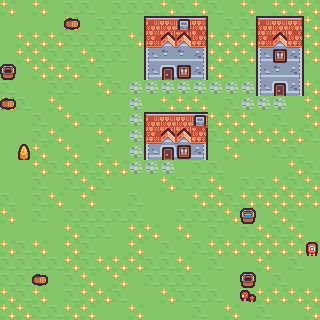

In [ ]:
dataset[0]["image"]

In [ ]:
dataset[0]["file_description"]

'A bucket full at (15, 13). A target at (19, 15). A bucket empty at (15, 17). A mushroom at (15, 18). A gray House with 2 windows at (16, 1) with width 3 and height 5. A gray House with 1 windows at (9, 7) with width 4 and height 3. A gray House with 2 windows at (9, 1) with width 4 and height 4. A orange tree at (1, 9). A log at (2, 17). A log at (4, 1). A bucket empty at (0, 4). A log at (0, 6). Path connecting points: (17, 5) (10, 9) (10, 4)   Relationships:  Relationships for House at (17.5, 3.5): - is diagonally above and to the right of House at (11, 8.5) (distance: 11.5 tiles). - is to the right of House at (11, 3) (distance: 7 tiles).  Relationships for House at (11, 8.5): - is diagonally below and to the left of House at (17.5, 3.5) (distance: 11.5 tiles). - is below House at (11, 3) (distance: 5.5 tiles).  Relationships for House at (11, 3): - is to the left of House at (17.5, 3.5) (distance: 7 tiles). - is above House at (11, 8.5) (distance: 5.5 tiles). '

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [10]:
instruction = "You are an expert tile-based map creator. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["file_description"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [12]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert tile-based map creator. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=320x320>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'A bucket full at (15, 13). A target at (19, 15). A bucket empty at (15, 17). A mushroom at (15, 18). A gray House with 2 windows at (16, 1) with width 3 and height 5. A gray House with 1 windows at (9, 7) with width 4 and height 3. A gray House with 2 windows at (9, 1) with width 4 and height 4. A orange tree at (1, 9). A log at (2, 17). A log at (4, 1). A bucket empty at (0, 4). A log at (0, 6). Path connecting points: (17, 5) (10, 9) (10, 4)   Relationships:  Relationships for House at (17.5, 3.5): - is diagonally above and to the right of House at (11, 8.5) (distance: 11.5 tiles). - is to the right of House at (11, 3) (distance: 7 tiles).  Relati

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [13]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert tile-based map creator. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This image showcases a tile-based map of a rural area, reminiscent of classic 16-bit games. The background features a green grass field, dotted with small brown, oval-shaped structures that may represent animals. A grey stone path with orange, triangular, ornate structures separates the path's ends in three areas along its middle section.

Three structures on the map stand out, with two larger houses on the right and a smaller one on the left. These structures resemble classic-style European buildings, featuring a light grey body, a red-orange, textured roof, a square window, and an ornate triangular area at the front, resembling a peaked roof


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [14]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [15]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.988 GB.
8.471 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 88 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 52,428,800
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.239800
2,0.730900
3,0.914600
4,1.143600
5,0.839200
6,0.988400
7,0.765200
8,0.669400
9,0.509300
10,0.597200


In [17]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1209.3376 seconds used for training.
20.16 minutes used for training.
Peak reserved memory = 19.072 GB.
Peak reserved memory for training = 10.601 GB.
Peak reserved memory % of max memory = 79.506 %.
Peak reserved memory for training % of max memory = 44.193 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [23]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert tile-based map creator. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

A single line fence at (12, 5). A target at (15, 12). A single line fence at (10, 10). A beehive at (11, 14). A bucket full at (12, 9). A gray House with 2 windows at (13, 7) with width 2 and height 3. A gray House with 2 windows at (5, 8) with width 3 and height 3. A gray House with 1 windows at (1, 9) with width 4 and height 4. Path connecting points: (15,


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
#model.save_pretrained("lora_model") # Local saving
#tokenizer.save_pretrained("lora_model")
model.push_to_hub("collectioncard/test2", token = "") # Online saving
tokenizer.push_to_hub("collectioncard/test2", token = "") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [1]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Hello, how are you"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

NameError: name 'dataset' is not defined

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [22]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
model.push_to_hub_merged("collectioncard/tiny_town_test", tokenizer, token = "")

100%|██████████| 5/5 [2:21:30<00:00, 1698.13s/it]  


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/drive/1j0N4XTY1zXXy7mPAhOC1_gMYZ2F2EBlk?usp=sharing)
4. Qwen 2 VL Vision finetuning - Maths OCR to LaTeX. [Free Colab](https://colab.research.google.com/drive/1whHb54GNZMrNxIsi2wm2EY_-Pvo2QyKh?usp=sharing)
5. Pixtral 12B Vision finetuning - General QA datasets. [Free Colab](https://colab.research.google.com/drive/1K9ZrdwvZRE96qGkCq_e88FgV3MLnymQq?usp=sharing)
6. More notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [Github](https://github.com/unslothai/unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

In [25]:
if True:
    model.push_to_hub_gguf(
        "collectioncard/tiny_model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

NotImplementedError: Unsloth: Sorry GGUF is currently not supported for vision models!